<a href="https://colab.research.google.com/github/CarlQGan/Arduino-CANBus/blob/main/2-svd_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low-Rank Approximation

In this section, you will be asked to investigated how the trade-off between
the selected ranks of SVD and its performance in terms of reconstruction
accuracy and speed-up (in clock-time and in FLOPS).

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a4-CarlQGan' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a4-CarlQGan
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [5]:
!ls {PROJECT_ROOT}


1-numerical_precision.ipynb  2-svd_rank.ipynb  data  mnist.py  README.md  src  tests


In [6]:
# Install required packgaes
!pip install torch numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [8]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
sys.path.insert(0, PROJECT_ROOT)

# 2. Rank v.s. Reconstruction Error

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the reconstruction error of the matrix (in the y-axis, measured by the Frobenius Norm).

NOTE: you can use `svd(A, torch.eye(A.shape(2), rank_A=<rank>, rank_B=None)` to do SVD, drop the rank
to `<rank>`, and return the reconstruction matrix of `A`.

We will provide a series of matrix for you to study. Please make one plot per matrix.
For each plot, comment on the trade-off between the number of ranks selected and the error by answering
the following questions:
1. Is the reconstruction error increasing or decreasing as we add more rank?
2. How fast is the reconstruction error change as we add more rank? Is it changing quickly or slowly? Why?
3. Is there a rank number below/above which the reconstruction error increase significantly?
4. What can you learn about this data?

In [20]:
from src.matmul import svd, naive
import torch
import matplotlib.image
# Pixels of a cute cat
A = torch.from_numpy(matplotlib.image.imread(f"{PROJECT_ROOT}/data/cat.png")).view(-1, 3)

In [11]:
# A batch of MNIST digit
import torch
A = torch.load(f"{PROJECT_ROOT}/data/mnist_act.pt")['act.0']

In [12]:
import torch
# A random matrix
A = torch.randn(512, 512)

In [13]:
import torch
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load(f"{PROJECT_ROOT}/data/mnist_act.pt")['act.1']

In [14]:
import torch
# Weight matrix of a fully connected neural network (trained on MNIST)
A = torch.load(f"{PROJECT_ROOT}/data/mnist_fc.pt")['fc2.weight']

Rank: 0, Error: 346250.15625
Rank: 1, Error: 1856.98583984375
Rank: 2, Error: 115.35330963134766
Rank: 3, Error: 108.53514099121094
Rank: 4, Error: 108.53514099121094
Rank: 5, Error: 108.53514099121094
Rank: 6, Error: 108.53514099121094
Rank: 7, Error: 108.53514099121094
Rank: 8, Error: 108.53514099121094
Rank: 9, Error: 108.53514099121094
Rank: 10, Error: 108.53514099121094


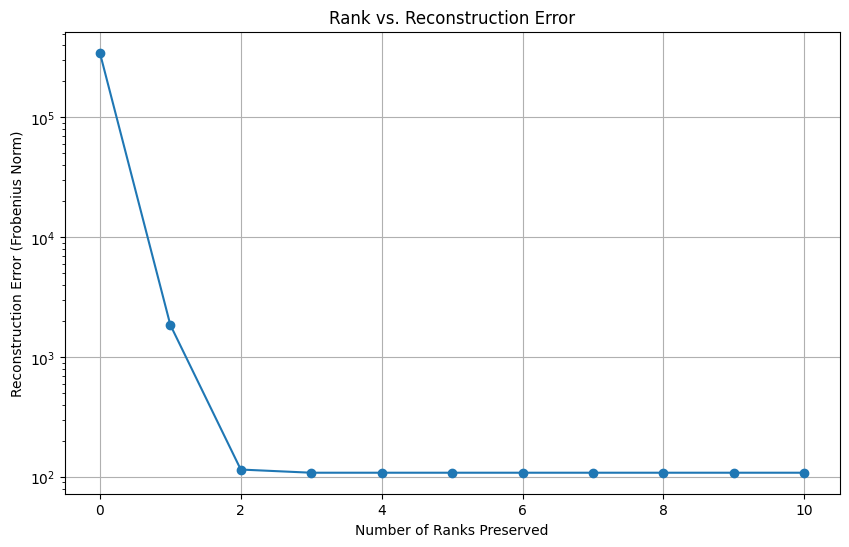

In [30]:
# List to store ranks and corresponding errors
ranks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
errors = []

def frobenius_norm_error(A, A_reconstructed):
    """
    Calculate the Frobenius norm of the error between the original matrix A
    and its reconstructed version A_reconstructed.

    Args:
    A (torch.Tensor): The original matrix.
    A_reconstructed (torch.Tensor): The reconstructed matrix after some operation, like SVD with reduced rank.

    Returns:
    float: The Frobenius norm of the difference between A and A_reconstructed.
    """
    return torch.norm(A - A_reconstructed).item()

# Perform the analysis
for rank in ranks:
    A_reconstructed = svd(A.T, A, rank, rank)
    error = frobenius_norm_error(naive(A.T, A), A_reconstructed)
    errors.append(error)
    print(f"Rank: {rank}, Error: {error}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(ranks, errors, marker='o')
plt.title('Rank vs. Reconstruction Error')
plt.xlabel('Number of Ranks Preserved')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.yscale('log')
plt.grid(True)
plt.show()

# 2. Rank v.s. Speed up

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the speed up of matrix-matrix multiply (in the y-axis, measured by both FLOPs and clock time)

You can assume both matrix A and B are using the same number of rank when approximating.

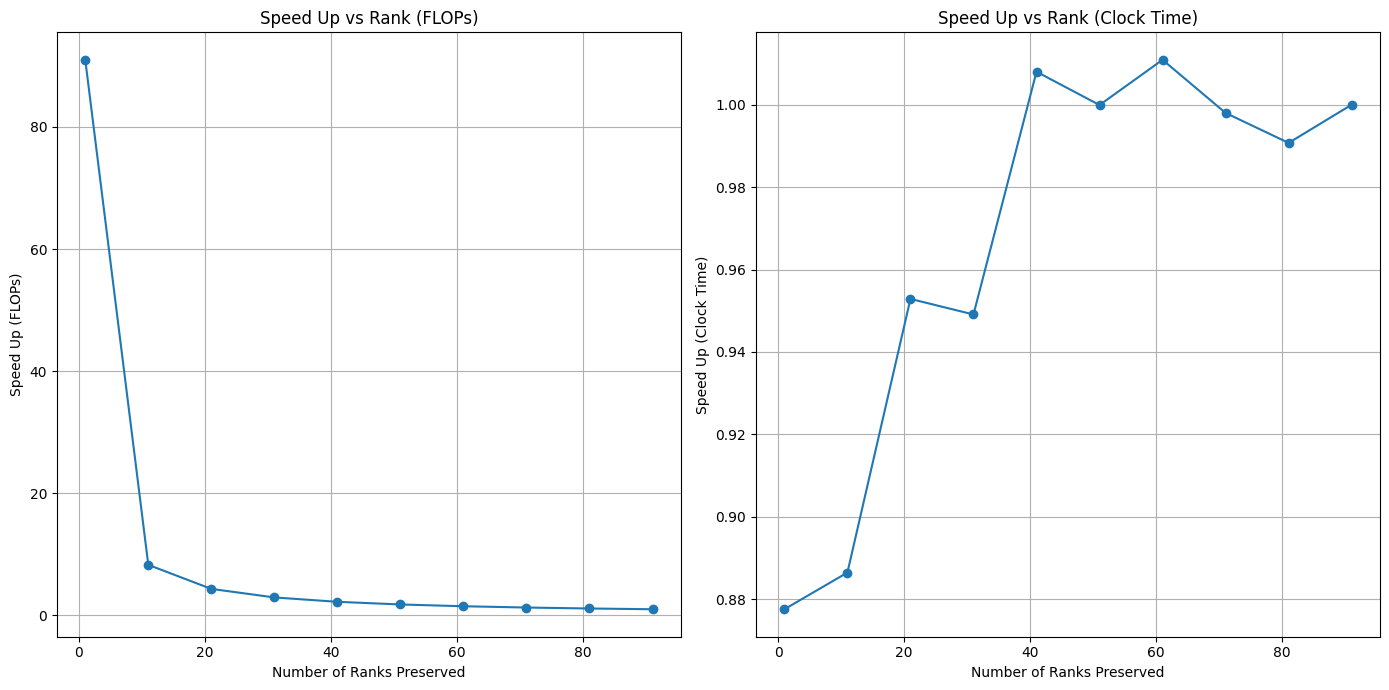

In [49]:
import time
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load(f"{PROJECT_ROOT}/data/mnist_act.pt")['act.1']

# Weight matrix of a fully connected neural network (trained on MNIST)
B = torch.load(f"{PROJECT_ROOT}/data/mnist_fc.pt")['fc2.weight'].transpose(0, 1)

def rank_reduced_multiplication(A, B, rank):
    # Measure time
    start_time = time.time()
    C = svd(A, B, rank, rank)
    elapsed_time = time.time() - start_time

    # Calculate FLOPs
    # For matrix multiplication, FLOPs is roughly 2*m*n*p (m x n) * (n x p)
    m, n = A.shape
    flops = 2 * m * n * rank

    return flops, elapsed_time

# Initialize matrices
n = 100
A = torch.randn(n, n)
B = torch.randn(n, n)

ranks = range(1, n+1, 10)  # Evaluate for ranks 1, 11, 21, ..., 91, 100
flops_list = []
times_list = []

for rank in ranks:
    flops, elapsed_time = rank_reduced_multiplication(A, B, rank)
    flops_list.append(flops)
    times_list.append(elapsed_time)

# Normalize values to show speed up
max_flops = flops_list[-1]
max_time = times_list[-1]

flops_speedup = [max_flops / flops for flops in flops_list]
time_speedup = [max_time / time for time in times_list]

# Plotting
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(ranks, flops_speedup, marker='o')
plt.title('Speed Up vs Rank (FLOPs)')
plt.xlabel('Number of Ranks Preserved')
plt.ylabel('Speed Up (FLOPs)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ranks, time_speedup, marker='o')
plt.title('Speed Up vs Rank (Clock Time)')
plt.xlabel('Number of Ranks Preserved')
plt.ylabel('Speed Up (Clock Time)')
plt.grid(True)

plt.tight_layout()
plt.show()